## Camera orientation

A video lecture covering camera orientation considerations can be found [here](https://www.youtube.com/embed/HoBKG82A9xs).  Please watch the first 30 minutes or so before Friday.

The data that I provided to you in coordinates.txt was already in the camera coordinate system.  What can we do when this is not the case.  For example, what if all you know is the coordinate values of some points in east (which we'll call $X$), north ($Y$), and elevation ($Z$), along with the location and rotational orientation of the camera?  We need to determine how to rotate the spatial coordinates of the world so that they are in the frame of reference of the camera, with $z$ pointing normal to the lens plane, and $x$ and $y$ parallel to it in the right and down directions.

First, what we need to do is to translate the spatial coordinates ($\mathbf{X}=\{X,Y,Z\}$) so that the camera ($\mathbf{X}_{cam} = \{X_{cam},Y_{cam},Z_{cam}\}$ is located at the origin.  This is straightforward:
$$
\mathbf{X}' = \mathbf{X} - \mathbf{X}_{cam}.
$$
This can also be done with a matrix multiplication, so long as the 3D coordinates are homogeneous, ie. there is a 1 appended to the end:
$$
\mathbf{X} = [X,Y,Z,1].
$$
Then, the translation matrix is
$$
T = \begin{bmatrix} 1 & 0 & 0 & -X_{cam} \\
                    0 & 1 & 0 & -Y_{cam} \\
                    0 & 0 & 1 & -Z_{cam} \\
                    0 & 0 & 0 & 1 \end{bmatrix}
$$
This gives us a Euclidean coordinate system that has its origin coincident with the location of the camera.  Now, we can perform rotations of the points such that they line up with the defined coordinate system of the camera, namely where $z$ is perpendicular to the camera focal plane, $x$ is to the right, and $y$ is down.

The thing we need to do is to apply yaw.  This represents the rotation of the camera in the horizontal plane.  We can define this in terms of azimuth, denoted $\phi$ where $\phi=0$ implies that the camera is pointed north, and is thus in line with the $Y$-axis in geographic coordinates.  Thus if we have a camera that is pointed $\phi$ degrees clockwise from north, the rotation matrix is 
$$
R_{yaw} = \begin{bmatrix} \cos\phi & -\sin\phi & 0 & 0 \\
                         \sin\phi & \cos\phi & 0 & 0 \\
                         0 & 0 & 1 & 0 \end{bmatrix}.
$$                         
Note that this is actually performing a counterclockwise rotation: what we actually want to do is rotate the points, not the camera (its coordinates are fixed).  Thus for a clockwise camera rotation, the points are rotated counterclockwise around the origin which is what $R_yaw \mathbf{X}'$ is doing.  Let's denote the axes of this new system as $\mathbf{X}''$  

Next, we can adjust for pitch.  As its commonly understood, this means to rotate around the axis which is horizontal, but parallel to the focal plane.  After our yaw operation, the $Y''$ axis is now pointing in the direction perpendicular to the focal plane and $Z''$ is pointing up, so we'll want to rotate around the $X''$ axis.  For pitch, a counterclockwise rotation (e.g. a rotation upwards) is usually thought of as being positive (this is simply a convention), so we'll need a clockwise rotation of the points.  This is given by
$$
R_{pitch} = \begin{bmatrix} 1 & 0 & 0 \\
                            0 & \cos\theta & \sin\theta \\
                            0 & -\sin\theta & cos\theta \end{bmatrix},
$$
where $\theta$ is the angle of the camera with respect to a plane passing through the $X''$ and $Y''$ axes.  This new coordinate system will be called $\mathbf{X}'''$  

Third, we can apply a roll matrix to account for camera being canted, or not "flat" in the side-to-side sense.  This is a rotation around the $Y$ axis:
$$
R_{roll} = \begin{bmatrix}  \cos\psi & 0 & -\sin\psi \\
                            0 & 1 & 0 \\
                            \sin\psi & 0 & cos\psi \end{bmatrix},
$$
where $\psi$ is the amount of roll present in the camera, measured clockwise from a plane passing through $X'''$ and $Y'''$.  This new coordinate system will be called $\mathbf{X}''''$

Applying these matrices in sequence will translate and rotate our points so that they are measured in the coordinate system where $Y''''$ is pointing normal to the camera focal plane, $X''''$ is parallel to it width-wise, and $Z''''$ is parallel to it height-wise.  This is fine, but the typical convention is that the third coordinate in the ordered triple ($Z''''$) should be normal to the camera plane, and the second ($Y''''$) should point down.  This means that we should apply one final rotation
$$
R_{axis} = \begin{bmatrix} 1 & 0 & 0 \\ 
                           0 & 0 & -1 \\
                           0 & 1 & 0 
\end{bmatrix}
$$
This one is simply a 90 degree counter clockwise rotation around the $X''''$ axis so that now $Z''''$ is pointing in the direction that $Y''''$ was before, and $Y''''$ is pointing in the negative $Z''''$ direction.  We'll call these final axes $\mathbf{x}=[x,y,z]$, which are the camera-centric coordinates we've been looking for.  

If we compose these matrices, we get a complete transformation matrix $C$:
$$
C = R_{axis} R_{roll} R_{pitch} R_{yaw} T,
$$
which maps from homogeneous geographical coordinates to homogeneous generalized coordinates.  
                     
Your objective is to write a function that generates this transformation matrix $C$ and applies it to an arbitrary set of points in the $X,Y,Z$ coordinate system.  To test your function, apply it to the attached file coordinates_ene.txt, assuming a camera azimuth of 45 degrees, a pitch of -10 degrees, and a roll of zero degrees, and camera coordinates easting=10000, northing=5000, elevation=1000.  Ensure that the resulting transformed coordinates look similar to those from coordinates.txt from the Jan. 14th assignment (Note that they won't be exactly the same, but the general sinusoidal shape of the resulting points should be the same.  This is because I used a different random number generator to produce each dataset).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [20]:
def rotate_points(pts, cam, roll, pitch, yaw):
    r_axis = np.array([[1, 0, 0], [0, 0,-1], [0, 1, 0]])
    r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], [0, 1, 0], [np.sin(roll), 0, np.cos(roll)]])
    r_pitch = np.array([[1, 0, 0], [0, np.cos(pitch), np.sin(pitch)], [0, -1*np.sin(pitch), np.cos(pitch)]])
    r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], [np.sin(yaw), np.cos(yaw), 0, 0], [0, 0, 1, 0]])
    
    T = np.array([[1, 0, 0, -cam[0]], [0, 1, 0, -cam[1]], [0, 0, 1, -cam[2]], [0, 0, 0, 1]])
    
    C = r_axis @ r_roll @ r_pitch @ r_yaw @ T
    
    return C @ pts

In [25]:
pts = np.loadtxt('coordinates_ene.txt')

pts = (np.c_[pts, np.ones(pts.shape[0])]).T

print(pts)

cam = [10000, 5000, 1000]
roll = 0
pitch = -10
yaw = 45

new_pts = rotate_points(pts, cam, roll, pitch, yaw)

print('\n', new_pts)

[[1.10267327e+04 1.05824627e+04 1.08137605e+04 ... 1.02561272e+04
  1.01981424e+04 1.02674873e+04]
 [6.07542472e+03 5.59743508e+03 6.25391600e+03 ... 5.56931479e+03
  5.58877113e+03 5.67155090e+03]
 [7.90785113e+02 7.99116308e+02 6.28175976e+02 ... 6.06363944e+02
  6.05377737e+02 6.09904094e+02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]

 [[ -375.71743035   607.07964178 -1320.90118535]
 [ -202.379152     271.81045392  -788.4843    ]
 [ -639.47528385   423.06243411 -1335.98430738]
 ...
 [ -349.88269735   -49.02274907  -647.95732411]
 [ -396.89889239   -71.13163675  -615.67046841]
 [ -430.90804577   -11.57593198  -699.20608492]]


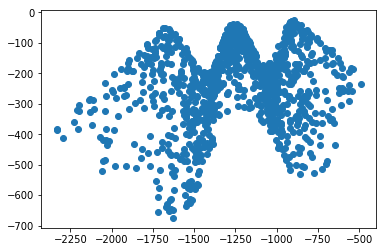

In [28]:
focal = 1000.
sensor = [2000.,1000.]

#General Coordinates
gcx = new_pts[:,0]/new_pts[:,2]
gcy = new_pts[:,1]/new_pts[:,2]

#Pixel Locations
pu = gcx*focal + sensor[0]/2.
pv = gcy*focal + sensor[1]/2.

plt.scatter(-1*pu, -1*pv, cmap='Greys')
plt.show()